# Task 04

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gti-upm/leapgestrecog")

print("Path to dataset files:", path)

100%|██████████| 2.13G/2.13G [00:10<00:00, 219MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gti-upm/leapgestrecog/versions/1


Loaded 20000 images with 10 gesture categories.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_n

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


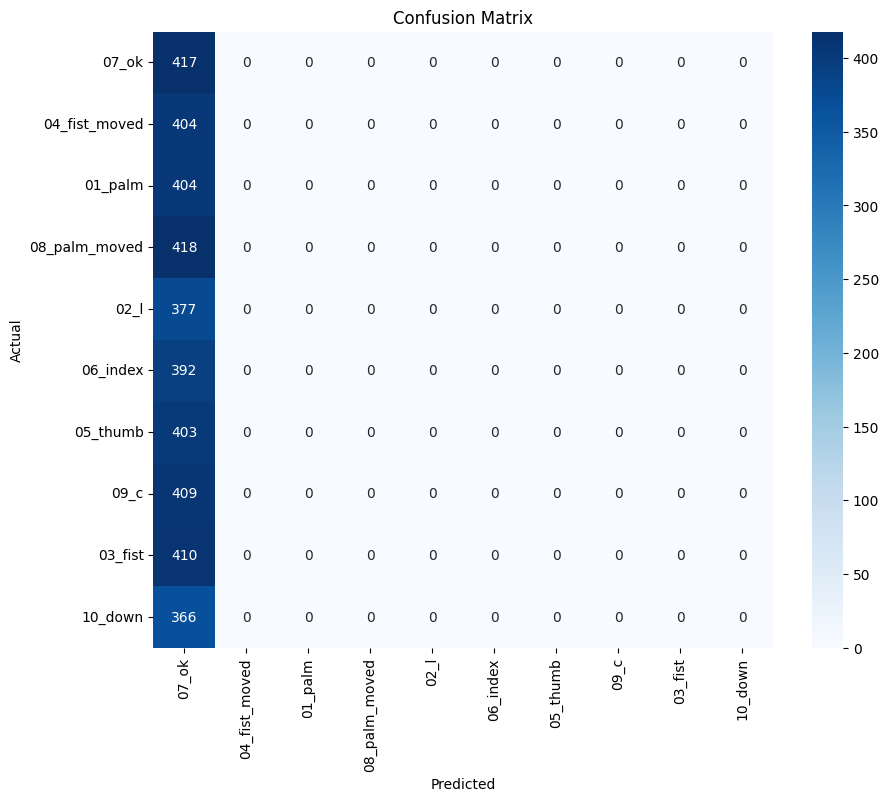

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Step 1: Path to Dataset
dataset_path = '/root/.cache/kagglehub/datasets/gti-upm/leapgestrecog/versions/1/leapGestRecog'

# Step 2: Load and Preprocess Dataset
def load_data(dataset_path, target_size=(64, 64)):
    images = []
    labels = []
    label_map = {}
    label_counter = 0

    for subject_folder in sorted(os.listdir(dataset_path)):
        subject_path = os.path.join(dataset_path, subject_folder)
        if os.path.isdir(subject_path):
            for gesture_folder in os.listdir(subject_path):
                gesture_path = os.path.join(subject_path, gesture_folder)
                if os.path.isdir(gesture_path):
                    # Assign a unique label to each gesture folder
                    if gesture_folder not in label_map.values():
                        label_map[label_counter] = gesture_folder
                        label_counter += 1
                    label = list(label_map.keys())[list(label_map.values()).index(gesture_folder)]

                    for img_file in os.listdir(gesture_path):
                        img_path = os.path.join(gesture_path, img_file)
                        try:
                            # Load image and resize
                            img = plt.imread(img_path)
                            img_resized = np.resize(img, (target_size[0], target_size[1], 3))
                            images.append(img_resized)
                            labels.append(label)
                        except Exception as e:
                            print(f"Error processing {img_path}: {e}")
                            continue

    return np.array(images), np.array(labels), label_map

images, labels, label_map = load_data(dataset_path)
print(f"Loaded {len(images)} images with {len(label_map)} gesture categories.")

# Normalize image data
images = images / 255.0

# Convert labels to categorical
labels = to_categorical(labels, num_classes=len(label_map))

# Step 3: Split Data into Training and Testing
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Step 4: Build the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_map), activation='softmax')
])

model.summary()

# Step 5: Compile the Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Data Augmentation for Training
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)

# Step 7: Train the Model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=25,
    verbose=1
)

# Step 8: Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Step 9: Generate Classification Report
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=list(label_map.values())))

# Step 10: Visualize Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
